In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif

# To convert large numbers into human-readable format
from numerize.numerize import numerize

# For suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Scikit-learn stuff
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

In [2]:
# Locate the dataset here
df = pd.read_csv("dataset/synthetic_fraud_dataset_processed.csv")
df.head()

,transaction_id,user_id,transaction_amount,transaction_method,account_balance,device_type,transaction_location,merchant_category,ip_address_flag,previous_fraudulent_activities,...,is_weekend,fraud_label,day_of_week,transaction_min,transaction_hour,transaction_month,transaction_date,transaction_amount_to_balance_ratio,is_high_value_transaction,card_age_years
0,TXN_33553,USER_1834,39.79,POS,93213.17,Laptop,Sydney,Travel,0,0,...,0,0,Monday,30,19,8,14,0.000427,False,5-10
1,TXN_9427,USER_7875,1.19,Bank Transfer,75725.25,Mobile,New York,Clothing,0,0,...,0,1,Wednesday,1,4,6,7,0.000016,False,10+
2,TXN_199,USER_2734,28.96,Online,1588.96,Tablet,Mumbai,Restaurants,0,0,...,0,1,Tuesday,25,15,6,20,0.018226,False,10+
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,76807.20,Tablet,New York,Clothing,0,0,...,0,1,Thursday,31,0,12,7,0.003311,True,5-10
4,TXN_39489,USER_2014,31.28,POS,92354.66,Mobile,Mumbai,Electronics,0,1,...,1,1,Saturday,44,23,11,11,0.000339,False,10+


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   transaction_id                       50000 non-null  object 
 1   user_id                              50000 non-null  object 
 2   transaction_amount                   50000 non-null  float64
 3   transaction_method                   50000 non-null  object 
 4   account_balance                      50000 non-null  float64
 5   device_type                          50000 non-null  object 
 6   transaction_location                 50000 non-null  object 
 7   merchant_category                    50000 non-null  object 
 8   ip_address_flag                      50000 non-null  int64  
 9   previous_fraudulent_activities       50000 non-null  int64  
 10  daily_transaction_count              50000 non-null  int64  
 11  avg_transaction_amount_7d   

Now, we want to drop/remove unnecessary columns, as such *transaction_id*, *user_id*, and *transaction_date* do not seem helpful in this context.

In [4]:
cols_to_drop = ["transaction_id", "user_id", "transaction_date"]
df = df.drop(cols_to_drop, axis = 1)
df.head()

,transaction_amount,transaction_method,account_balance,device_type,transaction_location,merchant_category,ip_address_flag,previous_fraudulent_activities,daily_transaction_count,avg_transaction_amount_7d,...,fraud_risk_score,is_weekend,fraud_label,day_of_week,transaction_min,transaction_hour,transaction_month,transaction_amount_to_balance_ratio,is_high_value_transaction,card_age_years
0,39.79,POS,93213.17,Laptop,Sydney,Travel,0,0,7,437.63,...,0.8494,0,0,Monday,30,19,8,0.000427,False,5-10
1,1.19,Bank Transfer,75725.25,Mobile,New York,Clothing,0,0,13,478.76,...,0.0959,0,1,Wednesday,1,4,6,0.000016,False,10+
2,28.96,Online,1588.96,Tablet,Mumbai,Restaurants,0,0,14,50.01,...,0.8400,0,1,Tuesday,25,15,6,0.018226,False,10+
3,254.32,ATM Withdrawal,76807.20,Tablet,New York,Clothing,0,0,8,182.48,...,0.7935,0,1,Thursday,31,0,12,0.003311,True,5-10
4,31.28,POS,92354.66,Mobile,Mumbai,Electronics,0,1,14,328.69,...,0.3819,1,1,Saturday,44,23,11,0.000339,False,10+


In [5]:
# Filtering categorical columns
categorical_col_names = ["transaction_method", "device_type", "transaction_location","merchant_category", 
                         "card_type", "authentication_method", "day_of_week", "card_age_years"]

In [6]:
# Splitting the data and set to variable X and Y respectively
X = df.drop("fraud_label", axis = 1)
y = df["fraud_label"]

Now, we will need a train and test data. With that, we have to split the data into those two.

In [7]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((40000, 24), (40000,)), ((10000, 24), (10000,)))

In [8]:
# Checking the number of instances for each class in the training set
print(f"Count of instances for the Negative Class: {len(y_train) - sum(y_train)}")
print(f"Count of instances for the Positive Class: {sum(y_train)}")

Count of instances for the Negative Class: 27185
Count of instances for the Positive Class: 12815


In [9]:
# Using OrdinalEncoder to encode the categorical data
encoder = OrdinalEncoder()
X_train.loc[:, categorical_col_names] = encoder.fit_transform(X_train.loc[:, categorical_col_names])
X_test.loc[:, categorical_col_names] = encoder.transform(X_test.loc[:, categorical_col_names])

In [10]:
# Using StandardScaler to scale the numerical data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Using SMOTE to resample the data
# Ignore the "File" cell output, seems to be an imblearn thing
smote_sampler = SMOTE(random_state=101)
X_train_resampled, y_train_resampled = smote_sampler.fit_resample(X_train, y_train)
(X_train_resampled.shape, y_train_resampled.shape)

((54370, 24), (54370,))

In [12]:
# Check the number of instances after resampling
print(f"Count of instances for the Negative Class: {len(y_train_resampled) - sum(y_train_resampled)}")
print(f"Count of instances for the Positive Class: {sum(y_train_resampled)}")

Count of instances for the Negative Class: 27185
Count of instances for the Positive Class: 27185


In [13]:
# This might not be necessary, but in case kNN is used, this will be necessary.
# Using SelectKBest to select best 15 features
selector = SelectKBest(score_func=f_classif , k=15)
selector.fit(X_train_resampled, y_train_resampled)


SelectKBest(k=15)

In [14]:
# Check the importance scores of each feature
feat_scores = pd.Series(selector.scores_, index=X.columns).sort_values(ascending = False)
feat_scores

failed_transaction_count_7d            20828.306559
fraud_risk_score                       10509.508285
transaction_amount_to_balance_ratio       15.556317
is_weekend                                15.103850
transaction_amount                         9.432676
transaction_location                       6.140022
device_type                                5.395012
is_high_value_transaction                  4.442317
daily_transaction_count                    3.211996
transaction_month                          3.166495
previous_fraudulent_activities             2.338559
transaction_method                         2.254680
card_age_months                            2.054094
ip_address_flag                            1.722768
transaction_min                            1.681690
merchant_category                          0.795511
card_age_years                             0.771610
transaction_hour                           0.576657
account_balance                            0.385868
card_type   

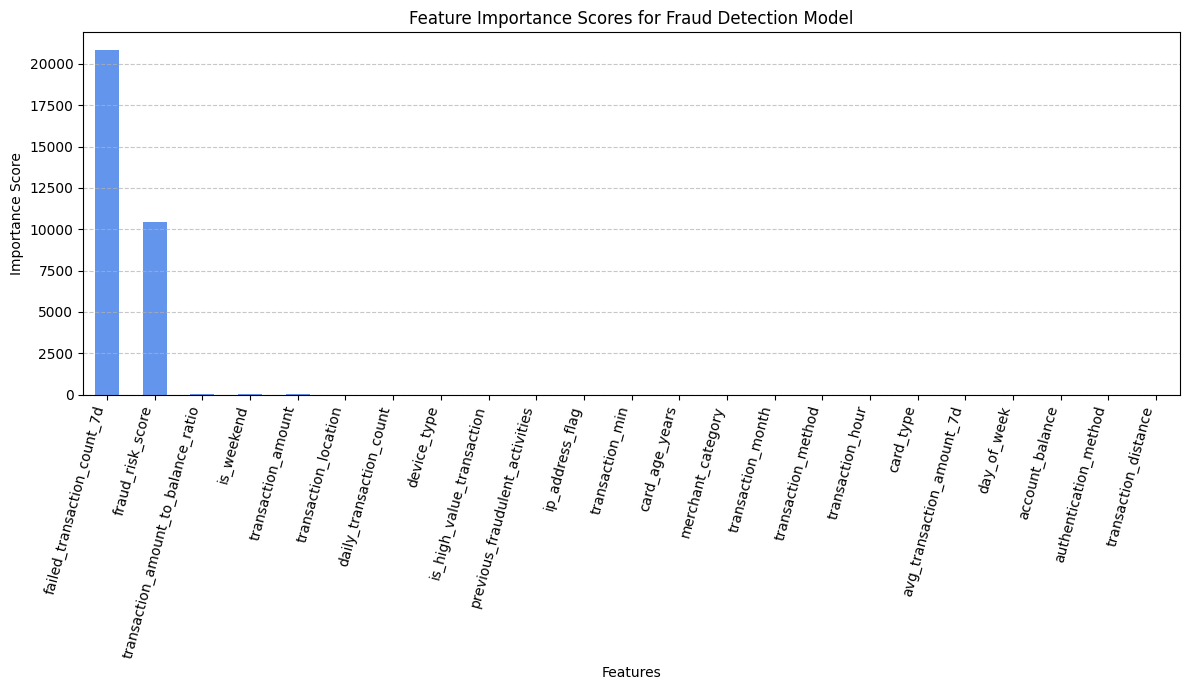

In [15]:
# Plotting the importance scores of each feature

feat_scores = pd.Series({
    'failed_transaction_count_7d': 20867.489928,
    'fraud_risk_score': 10443.666218,
    'transaction_amount_to_balance_ratio': 15.579663,
    'is_weekend': 11.958476,
    'transaction_amount': 9.713944,
    'transaction_location': 4.928634,
    'daily_transaction_count': 4.183587,
    'device_type': 4.174828,
    'is_high_value_transaction': 3.853186,
    'previous_fraudulent_activities': 2.320957,
    'ip_address_flag': 1.898779,
    'transaction_min': 1.707182,
    'card_age_years': 1.643722,
    'merchant_category': 1.408690,
    'transaction_month': 1.288288,
    'transaction_method': 0.911336,
    'transaction_hour': 0.746397,
    'card_type': 0.504604,
    'avg_transaction_amount_7d': 0.428079,
    'day_of_week': 0.257879,
    'account_balance': 0.220375,
    'authentication_method': 0.127043,
    'transaction_distance': 0.111210
}).sort_values(ascending=False)

plt.figure(figsize=(12, 7))
feat_scores.plot(kind='bar', color='cornflowerblue')
plt.title('Feature Importance Scores for Fraud Detection Model')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.xticks(rotation=75, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Interpretation

You may be asking, why did we have to check the importance scores of each feature? 

- The above values help us understand the importance of each feature in predicting fraudulent transactions.
- Features with higher values, such as *failed_transaction_count_7d, fraud_risk_score, and transaction_amount_to_balance_ratio*, are the most significant in distinguishing between fraudulent and non-fraudulent transactions.
- On the other hand, features like *card_type, avg_transaction_amount_7d, and authentication_method* have lower values, indicating that they contribute less to the prediction task.

In [16]:
# Checking the list of selected featuers
selected_cols = X.columns[selector.get_support()]
selected_cols

Index(['transaction_amount', 'transaction_method', 'device_type',
       'transaction_location', 'ip_address_flag',
       'previous_fraudulent_activities', 'daily_transaction_count',
       'failed_transaction_count_7d', 'card_age_months', 'fraud_risk_score',
       'is_weekend', 'transaction_min', 'transaction_month',
       'transaction_amount_to_balance_ratio', 'is_high_value_transaction'],
      dtype='object')

In [17]:
# Transforming the training and testing sets
X_train_resampled = selector.transform(X_train_resampled)
X_test = selector.transform(X_test)

In [18]:
models = {
    "RandomForestClassifier" : RandomForestClassifier(n_estimators=50, max_depth=7, class_weight="balanced", random_state=101),
    "XGBClassifier" : XGBClassifier(n_estimators=50, max_depth=7, enable_categorical = True, random_state = 101)
}

Now, let us put these models into action.

The code flow for this part is to:
1. Initialize a dict to store model performances
2. KFold cross-validation to build more robust models
3. Loop through both models, training them, and evaluating
4. Store their performance based on the performance metrics specified earlier

In [19]:
model_performance = {}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Looping through both models
for model_name, model in models.items():
    print(f"Training {model_name}")

    model.fit(X_train_resampled, y_train_resampled)
    
    # Making predictions on the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC
    
    # Training and Testing CV Scores
    training_cv_score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=skf, scoring = "roc_auc")
    testing_cv_score = cross_val_score(model, X_test, y_test, cv=skf, scoring = "roc_auc")
    
    # Evaluating the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store them
    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc,
        "Avg Training CV Score" : np.mean(training_cv_score),
        "Avg Testing CV Score" : np.mean(testing_cv_score),
        "Trainning CV Score Std" : np.std(training_cv_score),
        "Testing CV Score Std" : np.std(testing_cv_score)
    }
    
    print(f"Done Training {model_name}\n")
   

Training RandomForestClassifier
Done Training RandomForestClassifier

Training XGBClassifier
Done Training XGBClassifier



In [20]:
model_performance_df = pd.DataFrame(model_performance)
model_performance_df

,RandomForestClassifier,XGBClassifier
Accuracy,1.000000,0.998000
Precision,1.000000,0.996620
Recall,1.000000,0.997232
F1-Score,1.000000,0.996926
ROC AUC,1.000000,0.999992
Avg Training CV Score,0.999950,0.999977
Avg Testing CV Score,1.000000,0.999996
Trainning CV Score Std,0.000098,0.000028
Testing CV Score Std,0.000000,0.000007


#### So, who wins? Random Forest or XGBoost?

Based on what we can see on the scores alone, even if you do not know how to understand code, we can see that:

**Best Performance:**
- **Random Forest** with all of the metrics. This model show minimal variation in cross-validation scores, which indicates excellent generalizability and significant overfitting. The **ROC-AUC** score of 1.0 for this model confirms their exceptional ability to distinguish between positive and negative classes.

While **Random Forest** stole the show, **XGBoost** also performed really well with a near-perfect accuracy of 0.998 and a high **AUC-ROC** score of 0.999. I mean, if you round it up, it should be 1.0 like Random Forest, but obviously, that is not something we should do here. Now, the same also goes for the other metrics.